In [5]:
# Import necessary libraries
%pip install shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import shap
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_text, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# To suppress boring warnings...
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Note: you may need to restart the kernel to use updated packages.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1002.0+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 14249 entries, 0 to 14248
Series name: status
Non-Null Count  Dtype 
--------------  ----- 
14249 non-null  object
dtypes: object(1)
memory usage: 111.4+ KB
None


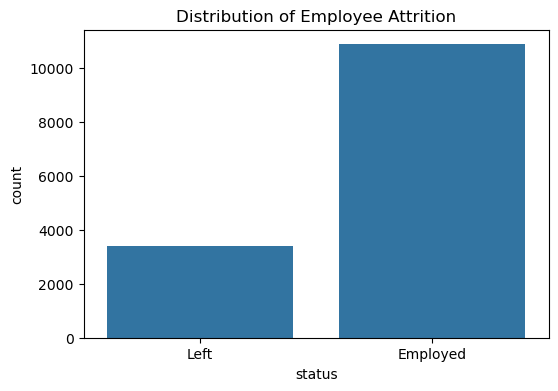

In [6]:
#Load dataset
datasets  = {}
df = pd.read_csv('employee_churn.csv')
X, y = df.drop(['status'], axis=1), df['status']
feature_names = X.columns.tolist()
class_names = y.unique().tolist()
print(X.info())
print(y.info())
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribution of Employee Attrition')
plt.show()

In [7]:
# set random seed for reproducibility
seed = 42
# Create data preprocessor
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', cat_pipeline, X.select_dtypes(include=['object']).columns)
    ])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

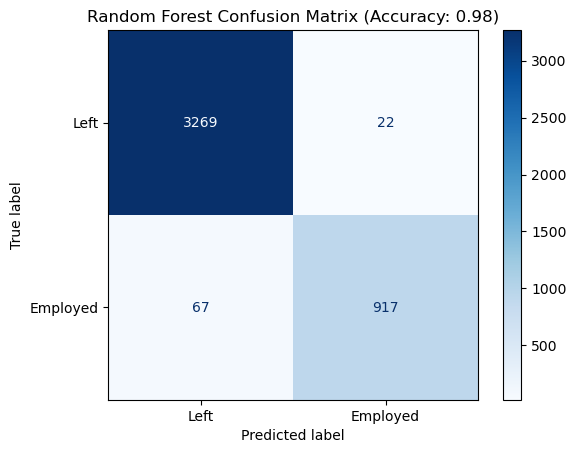

In [8]:
# Create a pipeline with preprocessor and Random Forest classifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=seed))
])
# Hyperparameter tuning for Random Forest
rf_params = {
    'classifier__n_estimators': [10, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 5],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}
# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=rf_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title(f'Random Forest Confusion Matrix (Accuracy: {accuracy_rf:.2f})')
plt.show()

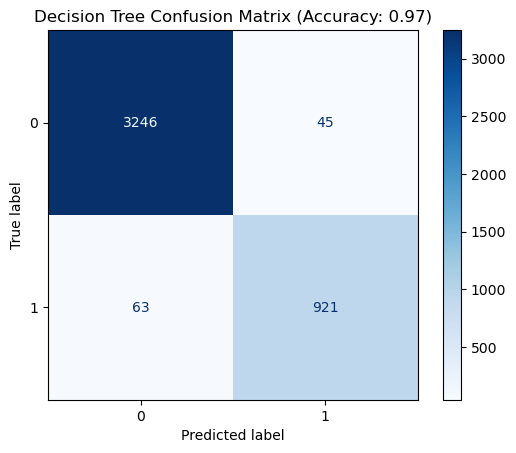

In [9]:
# Create a pipeline with preprocessor and Decision Tree classifier
pipeline_de = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=seed,class_weight="balanced"))
])
# Hyperparameter tuning for Decision Tree
de_params = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 5],
    'classifier__class_weight': [None, 'balanced']
}
# Perform grid search with cross-validation
grid_search_de = GridSearchCV(pipeline_de, param_grid=de_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_de.fit(X_train, y_train)
best_de_model = grid_search_de.best_estimator_
y_pred_de = best_de_model.predict(X_test)
accuracy_de = accuracy_score(y_test, y_pred_de)
cm_de = confusion_matrix(y_test, y_pred_de)
disp_de = ConfusionMatrixDisplay(confusion_matrix=cm_de)
disp_de.plot(cmap=plt.cm.Blues)
plt.title(f'Decision Tree Confusion Matrix (Accuracy: {accuracy_de:.2f})')
plt.show()

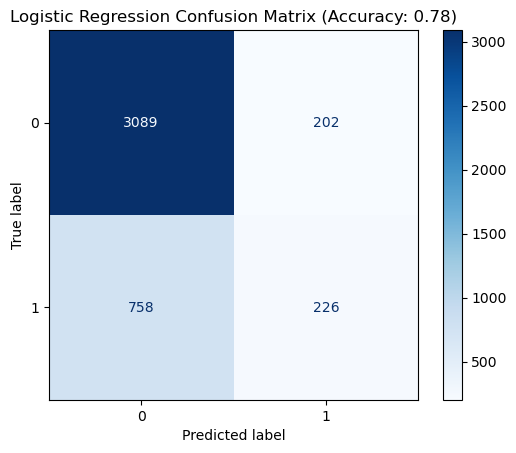

In [10]:
# Create a pipeline with preprocessor and LogisticRegression classifier
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=seed))
])
# Hyperparameter tuning for Logistic Regression
lr_params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}
# Perform grid search with cross-validation
grid_search_lr = GridSearchCV(pipeline_lr, param_grid=lr_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title(f'Logistic Regression Confusion Matrix (Accuracy: {accuracy_lr:.2f})')
plt.show()

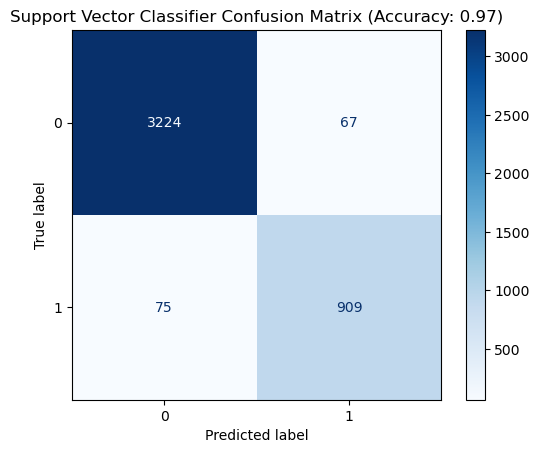

In [11]:
# Create a pipeline with support vector classifier
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=seed))
])
# Hyperparameter tuning for Support Vector Classifier
svc_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__class_weight': [None, 'balanced']
}
# Perform grid search with cross-validation
grid_search_svc = GridSearchCV(pipeline_svc, param_grid=svc_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)
best_svc_model = grid_search_svc.best_estimator_
y_pred_svc = best_svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot(cmap=plt.cm.Blues)
plt.title(f'Support Vector Classifier Confusion Matrix (Accuracy: {accuracy_svc:.2f})')
plt.show()

In [12]:
# SHAP explanations for the best Random Forest model
explainer_rf = shap.TreeExplainer(best_rf_model.named_steps['classifier'],
                                best_rf_model.named_steps['preprocessor'].transform(X_train))
shap_values_rf = explainer_rf(best_rf_model.named_steps['preprocessor'].transform(X),check_additivity=False)

100%|===================| 28492/28498 [11:38<00:00]        

In [13]:
# Save results to CSV files for visualization in tableau
df_export = X.copy()
shap_values_array = shap_values_rf.values
shap_values_class1 = shap_values_array[:, :, 1]
# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(
    shap_values_class1,
    columns=best_rf_model.named_steps['preprocessor'].get_feature_names_out(),
    index=X.index
)
# Add actual and predicted values to the export DataFrame
df_export['Actual'] = y
df_export['Predicted'] = best_rf_model.predict(X)
#Add ID column
df_export['ID'] = X.index
shap_values_array = shap_values_rf.values
# Concat SHAP values and export to CSV
df_export = pd.concat([df_export,shap_df.add_prefix('SHAP_')], axis=1)
df_export.to_csv('employee_attrition_shap_results.csv', index=False)
print(df_export.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   avg_monthly_hrs                              14249 non-null  int64  
 1   department                                   13540 non-null  object 
 2   filed_complaint                              2058 non-null   float64
 3   last_evaluation                              12717 non-null  float64
 4   n_projects                                   14249 non-null  int64  
 5   recently_promoted                            300 non-null    float64
 6   salary                                       14249 non-null  object 
 7   satisfaction                                 14068 non-null  float64
 8   tenure                                       14068 non-null  float64
 9   Actual                                       14249 non-null  object 
 10